# Simple cadCAD Template

This is a template that will allow you to start a cadCAD experiment without needing to fork another project.

## Check cadCAD

This cell doesn't do anything, but it does ensure that you know what version of cadCAD you're running. That way if/when you encounter technical difficulties you can tell the community which version of cadCAD you're running. Might save you hours of pain if all you need to do is upgrade to the latest version. 

In [1]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /usr/local/lib/python3.8/site-packages
Requires: fn, funcy, pathos, pandas
Required-by: cadCAD-diagram
Note: you may need to restart the kernel to use updated packages.


## Import Stuff

These are the libraries you'll need (cadCAD stuff) and that could be useful (python stuff) for your cadCAD model.

In [2]:
# python stuff
import numpy as np
import random as random

# cadCAD stuff
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

## Initial Params

These are the parameters that control the behavior of a system. For example, if you were modeling a Web3 protocol these would be the parameters within a system that token holders could vote to modify. All of the parameters of a protocol that can be modified should be accessible here. That way it's easy to modify and run similations to explore how parameter changes might affect the network.

In [3]:
# the initial state of the cadCAD model
# in a stock and flow model you can think of this as the stocks
genesis_states = {
    # stuff goes here
    'stuff': 1,
    # things
    'things': 100, 
    # etc
    'etc': 50,
}

# The parameters to run the model
# Often these are found towards the end of the file near the cadCAD engine
# but we're putting them here so that you can easily configure and run 
# the notebook without having to scroll back and forth
sim_config_dict = {
    # timesteps
    'T': range(100), 
    # parallel runs
    'N': 3,
    # more advanced stuff
    #'M': {}
}

## Policy Functions

Policy functions are like flows in stock and flow diagrams. They modify the inputs to state update functions.

In [4]:
# We start policy functions with p_ so that they're easier to keep track of
# when we put them into state update blocks. 
def p_modify_stuff(params, step, sH, s):
    # a data point that's useful for something
    data_point = np.random.randint(1, s['things'])
    # returns a python dictionary item
    return ({'data_point': data_point})


## State Update Functions

These functions take in inputs (state variables and policies) and modify the state.

In [5]:
# We start state update functions with s_ so that they're easier to keep track of
# when we put them into state update blocks. 
def s_modify_state(params, step, sH, s, _input):
    y = 'stuff'
    x = s[y]
    add_stuff = round(s['things'] / _input['data_point'])
    x += add_stuff
    return (y, x)


## State Update Block

If you're approaching cadCAD from Web3 you can think of the state of the model as something that evolves in blocks. Each block has a set of actions that updates the state. Those transactions then get batched into blocks to be processed together. In cadCAD blocks are called "`partial_state_update_blocks`." As you can see below, this is an array that is very similar to a "block" in a blockchain in that it represents a set of actions to update the state. That state is then updated across many timesteps. This is similar to how the state of a blockchain is updated over many timesteps as new blocks are added.



In [6]:
partial_state_update_blocks = [
    { 
        # policies represent the behavior of agents that interact with components of the system
        'policies': { 
            'data_point': p_modify_stuff
        },
        # state variables that will be updated
        'variables': {
            'stuff': s_modify_state
        }
    }
]

## Running the cadCAD Engine

In [7]:
# imported some addition utilities to help with configuration set-up
exp = Experiment()
c = config_sim(sim_config_dict)
# The configurations above are then packaged into a `Configuration` object
del configs[:]
# dict containing variable names and initial values
exp.append_configs(initial_state=genesis_states, 
                    # dict containing state update functions 
                    partial_state_update_blocks=partial_state_update_blocks, 
                    # preprocessed dictionaries containing simulation parameters
                    sim_configs=c)


In [8]:
%%capture
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

# pass the configuration object inside an array
simulation = Executor(exec_context=local_mode_ctx, configs=configs) 
# the `execute()` method returns a tuple; its first elements contains the raw results
raw_system_events, tensor_field, sessions = simulation.execute() 

## Data Visualization

This is often half the battle. Not only do need to design and build a cadCAD model, but you need to understand how it's working and be able to effectively communicate that to other people. A picture says a thousand words, thus enter data viz. Getting good at using python data viz libraries is probably the highest leverage thing you can do after you learn the cadCAD basics.

In [9]:
%matplotlib inline
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

stuff  things  etc  simulation
subset run timestep substep                                
0      1   0        0            1     100   50           0
           1        1            3     100   50           0
           2        1            5     100   50           0
           3        1            7     100   50           0
           4        1            8     100   50           0
...                            ...     ...  ...         ...
       3   96       1          450     100   50           0
           97       1          451     100   50           0
           98       1          456     100   50           0
           99       1          458     100   50           0
           100      1          459     100   50           0

[303 rows x 4 columns]

<AxesSubplot:xlabel='timestep'>

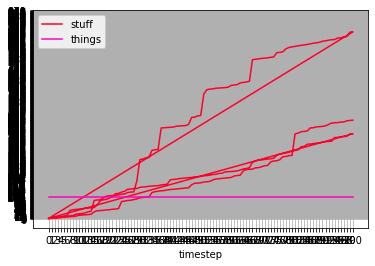

In [10]:
simulation_result.plot('timestep', ['stuff', 'things'], grid=True, 
        colormap = 'gist_rainbow',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['stuff']+simulation_result['things']).max())))